In [1]:
import io
import os
import pickle
import random as rn
import warnings
from datetime import datetime
from importlib import reload
from multiprocessing import cpu_count

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText
from IPython.display import display
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, ndcg_score, \
        label_ranking_average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import data
import models
import preprocessing

seed = 42
sns.set()

def reset_seed():
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    np.random.seed(seed)
    rn.seed(seed)
    tf.random.set_seed(seed)

## Choose notebook version

In [2]:
version = "tokenized_cased"
# version = "tokenized_no_sw_no_punct"
# version = "tokenized_lemmatized_no_sw_no_punct"

## Extracting the data

In [3]:
# data.extract_data(extraction_dir="train",
#                   data_dir="data",
#                   data_zip_name="reuters-training-corpus.zip")

train_df = pd.read_pickle("train/data.pkl")

# train_df = data.get_docs_labels("train/REUTERS_CORPUS_2")
# train_df.to_pickle("train/data.pkl")

train_docs = train_df["doc"].values
n_train = train_docs.shape[0]
train_labels = np.array(train_df["labels"].tolist())
n_labels = len(data.CODEMAP)

# extract test_docs here

print(train_docs.shape)
print(train_labels.shape)
print(train_docs[2])
print(train_labels[2])

(299773,)
(299773, 126)
Toronto stocks end higher after volatile session. CHANGE				    CHANGE TSE	  5900.37    +50.15   HI 5900.37	    LO  5840.29 DJI	  6611.05    +27.57   GOLD (LONDON)   US$350.00 +1.90 FTSE100    4248.10    -64.80   GOLD (NY-COMEX) US$354.80 +0.70 NIKKEI    17869.59   -133.81   LME CASH NICKEL US$7659   +99.0 CANDLR	1.3883		 LME CASH ALUM   US$1602.0  -4.0 CAN 30-YR   107.41     -0.15   BRENT CRUDE     US$19.09  -0.27 --------------------MARKET COMMENT---------------------------- * Toronto stocks ended higher on Tuesday, buoyed by strength in golds and banking * Computer problems due to heavy trading in Bre-X Minerals hampered session * 84 million shares traded Toronto's key stock index ended higher on Tuesday as the saga of Bre-X Minerals Ltd and its Indonesian gold find continued to dominate Canada's biggest stock market. The TSE 300 Index climbed 50.15 points to close at 5900.37 in heavy turnover of 84.07 million shares worth C$1.4 billion. But the overall marke

## Preprocessing the documents

In [4]:
path_to_preprocessed_train_docs = f"train/preprocessed_docs_{version}.pkl"

try:
    with open(path_to_preprocessed_train_docs, "rb") as f:
        preprocessed_train_docs = pickle.load(f)
except:
    preprocessed_train_docs = preprocessing.preprocess_corpus(train_docs)
    with open(path_to_preprocessed_train_docs, "wb") as f:
        pickle.dump(preprocessed_train_docs, f)

print(preprocessed_train_docs[2])

Toronto stocks end higher after volatile session . CHANGE CHANGE TSE 5900.37 +50.15 HI 5900.37 LO 5840.29 DJI 6611.05 +27.57 GOLD ( LONDON ) US$ 350.00 +1.90 FTSE100 4248.10 -64.80 GOLD ( NY - COMEX ) US$ 354.80 +0.70 NIKKEI 17869.59 -133.81 LME CASH NICKEL US$ 7659 +99.0 CANDLR 1.3883 LME CASH ALUM US$ 1602.0 -4.0 CAN 30-YR 107.41 -0.15 BRENT CRUDE US$ 19.09 -0.27 --------------------MARKET COMMENT---------------------------- * Toronto stocks ended higher on Tuesday , buoyed by strength in golds and banking * Computer problems due to heavy trading in Bre - X Minerals hampered session * 84 million shares traded Toronto 's key stock index ended higher on Tuesday as the saga of Bre - X Minerals Ltd and its Indonesian gold find continued to dominate Canada 's biggest stock market . The TSE 300 Index climbed 50.15 points to close at 5900.37 in heavy turnover of 84.07 million shares worth C$ 1.4 billion . But the overall market was mixed with declining issues narrowly outpacing advances 476

In [5]:
# path_to_preprocessed_test_docs = f"test/preprocessed_docs_{version}.pkl"

# try:
#     with open(path_to_preprocessed_test_docs, "rb") as f:
#         preprocessed_test_docs = pickle.load(f)
# except:
#     preprocessed_test_docs = preprocessing.preprocess_corpus(test_docs)
#     with open(path_to_preprocessed_test_docs, "wb") as f:
#         pickle.dump(preprocessed_test_docs, f)

# print(preprocessed_test_docs[2])

## Representing the documents as token index sequences

In [6]:
docs = preprocessed_train_docs # add preprocessed_test_docs
n_vocabulary = None

In [7]:
tokenizer = Tokenizer(num_words=n_vocabulary, filters="", lower=False)
tokenizer.fit_on_texts(docs)
word_idx = tokenizer.word_index
if n_vocabulary is None:
    n_vocabulary = len(word_idx) + 1 # use index 0 for padding

print(n_vocabulary)

721935


In [8]:
n_sequence = 1280

sequences = tokenizer.texts_to_sequences(docs)
if n_sequence is None:
    n_sequence = max([len(s) for s in sequences])
sequence_lengths = [min(len(s), n_sequence) for s in sequences]
sequences = pad_sequences(sequences,
                          maxlen=n_sequence,
                          padding="post",
                          truncating="post")

print(n_sequence)
print(sequences.shape)
print(sequences[2][:100])

1280
(299773, 1280)
[  2112    217    137    145     52   2639    593      2   3714   3714
   9473 222813 376439   8514 222813   9051 376440  30534 170526 271220
   4802     14   2981     13    587  22026 123436  55200 376441 376442
   4802     14   3274      7   3355     13    587 222814  66463  15304
 376443 191283   1660   5594  16940    587 376444 376445  24154 191284
   1660   5594  23347    587 376446  14783   1709  11671 115825  34203
  15729  13077    587  40699  46144  32689  36483     38   2112    217
    226    145     12     85      3   5774     23   1043      6  11672
      9    809     38   3318    700    167      4    901    181      6
   3495      7   1927   6603   9271    593     38   4214     31     75]


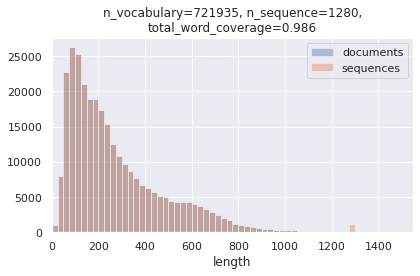

In [9]:
doc_lengths = [len(doc.split()) for doc in docs]

sns.distplot(doc_lengths,
             bins=np.arange(0, 2500, 25),
             kde=False,
             label="documents")
sns.distplot(sequence_lengths,
             bins=np.arange(0, 2500, 25),
             kde=False,
             label="sequences")
total_word_coverage = np.round(np.sum(sequence_lengths) / np.sum(doc_lengths), 3)
plt.title(f"n_vocabulary={n_vocabulary}, n_sequence={n_sequence},\n"
          f"total_word_coverage={total_word_coverage}")
plt.xlim(0, 1550)
plt.xlabel("length")
plt.legend()
plt.tight_layout()
plt.show()

## Word embeddings

In [10]:
n_embedding = 300 # 300 required by pretrained embeddings

### FastText

In [11]:
reset_seed()

# ft_path = f"data/fasttext_{version}.model"
ft_path = f"train/fasttext_{version}.model"

try:
    ft = FastText.load(ft_path)
except:
    ft = FastText(sentences=[doc.split() for doc in docs], size=n_embedding,
                  min_count=1, workers=cpu_count(), seed=seed)
    ft.save(ft_path)

print(len(list(ft.wv.vocab)))
print(ft.wv.index2entity[:100])

721934
['the', '.', ',', 'to', 'of', 'in', '-', 'a', 'and', '"', 'said', 'on', ')', '(', "'s", 'for', 'The', 'at', 'was', '$', 'that', 'is', 'by', 'with', 'from', 'percent', 'it', 'be', '/', 'as', 'million', 'its', 'will', 'has', '--', 'were', 'not', '*', 'would', 'year', 'are', 'have', 'an', 'he', 'which', ':', 'had', 'market', 'up', 'A', 'but', 'after', 'N', 'this', 'company', 'one', 'been', 'U.S.', 'billion', 'also', 'government', 'last', 'or', '1997', 'two', 'their', 'they', 'first', 'over', 'new', '1', 'his', 'more', 'June', 'shares', 'about', 'week', 'It', 'than', 'share', 'Bank', 'who', 'I', '1996', 'Tuesday', '%', 'per', 'Wednesday', 'May', 'we', 'expected', 'July', 'Thursday', 'Monday', 'We', 'some', 'Friday', 'down', 'could', 'three']


### Word2Vec

In [12]:
reset_seed()

# w2v_path = f"data/w2v_{version}.model"
w2v_path = f"train/w2v_{version}.model"

try:
    w2v = Word2Vec.load(w2v_path)
except:
    w2v = Word2Vec(sentences=[doc.split() for doc in docs], size=n_embedding,
                   min_count=1, workers=cpu_count(), seed=seed)
    w2v.save(w2v_path)

print(len(list(w2v.wv.vocab)))
print(w2v.wv.index2entity[:100])

721934
['the', '.', ',', 'to', 'of', 'in', '-', 'a', 'and', '"', 'said', 'on', ')', '(', "'s", 'for', 'The', 'at', 'was', '$', 'that', 'is', 'by', 'with', 'from', 'percent', 'it', 'be', '/', 'as', 'million', 'its', 'will', 'has', '--', 'were', 'not', '*', 'would', 'year', 'are', 'have', 'an', 'he', 'which', ':', 'had', 'market', 'up', 'A', 'but', 'after', 'N', 'this', 'company', 'one', 'been', 'U.S.', 'billion', 'also', 'government', 'last', 'or', '1997', 'two', 'their', 'they', 'first', 'over', 'new', '1', 'his', 'more', 'June', 'shares', 'about', 'week', 'It', 'than', 'share', 'Bank', 'who', 'I', '1996', 'Tuesday', '%', 'per', 'Wednesday', 'May', 'we', 'expected', 'July', 'Thursday', 'Monday', 'We', 'some', 'Friday', 'down', 'could', 'three']


### Pre-trained FastText

In [13]:
def load_embeddings(fname, skip_first):
    embedding_idx = {}
    with open(fname, "r", encoding="utf-8", errors="ignore") as f:
        for i, line in enumerate(f):
            if i == 0 and skip_first:
                continue
            vals = line.rstrip().split()
            token = "".join(vals[:-300])
            embedding = np.array(vals[-300:], dtype=np.float32)
            embedding_idx[token] = embedding
    return embedding_idx

In [14]:
ft_pretrained = load_embeddings("data/crawl-300d-2M.vec", skip_first=True)

token_iter = iter(ft_pretrained)
print([next(token_iter) for i in range(100)])

[',', 'the', '.', 'and', 'to', 'of', 'a', 'in', 'is', 'for', 'that', 'I', 'it', 'on', 'with', ')', ':', '"', '(', 'The', 'you', 'was', 'are', 'or', 'this', 'as', 'have', 'at', 'from', '!', "'s", 'but', 'by', 'not', '?', 'your', 'all', '/', 'be', 'we', 'my', 'one', '-', 'will', 'they', 'so', 'which', '”', '“', 'has', '...', 'just', 'he', 'their', 'can', 'about', 'his', 'our', ';', 'when', 'more', 'had', 'do', 'some', 'time', 'like', 'also', 'there', 'them', 'get', 'what', 'out', "'", 'me', 'her', 'an', 'were', 'This', 'It', 'up', 'would', 'if', 'who', 'new', 'only', 'A', '–', 'people', 'any', 'We', 'make', 'other', 'In', 'then', 'its', 'use', 'said', 'now', 'no', 'first']


### Pre-trained GloVe

In [ ]:
if version == "tokenized_cased":
    glove_pretrained = load_embeddings("data/glove.840B.300d.txt", skip_first=False)
else:
    glove_pretrained = load_embeddings("data/glove.42B.300d.txt", skip_first=False)
    
token_iter = iter(glove_pretrained)
print([next(token_iter) for i in range(100)])

### Embedding matrices

In [ ]:
def create_embedding_matrix(embedding_model):
    embedding_matrix = np.zeros((n_vocabulary, n_embedding))
    unknown_token_count = 0
    for token, i in word_idx.items():
        if i >= n_vocabulary:
            continue
        if token in embedding_model:
            embedding_matrix[i] = embedding_model[token]
        else:
            unknown_token_count += 1

    print(unknown_token_count)
    print(embedding_matrix.shape)
    print(embedding_matrix[1][:20])

    return embedding_matrix

In [ ]:
ft_embedding_matrix = create_embedding_matrix(ft)

In [ ]:
w2v_embedding_matrix = create_embedding_matrix(w2v)

In [ ]:
ft_pretrained_embedding_matrix = create_embedding_matrix(ft_pretrained)

In [ ]:
glove_pretrained_embedding_matrix = create_embedding_matrix(glove_pretrained)

## Shuffling the data

In [ ]:
n_samples = None
x_train, y_train = shuffle(sequences[:n_train],
                           train_labels,
                           random_state=seed,
                           n_samples=n_samples)

## Cross-evaluating the models

In [ ]:
def cross_evaluate(model_initializer, batch_size=256, model_params={}):
    model_initializer(n_vocabulary, n_embedding, n_sequence, n_labels,
                      **model_params).summary()

    cv_scores = []
    mskf = MultilabelStratifiedKFold(n_splits=5, random_state=seed)
    for train, val in mskf.split(x_train, y_train):
        model = model_initializer(n_vocabulary, n_embedding, n_sequence, n_labels,
                                  **model_params)
        es = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)
        history = model.fit(x_train[train],
                            y_train[train],
                            batch_size=batch_size,
                            epochs=100,
                            verbose=1,
                            validation_data=(x_train[val], y_train[val]),
                            callbacks=[es])

        y_pred_prob = model.predict(x_train[val], batch_size=batch_size, verbose=1)
        y_pred = np.round(y_pred_prob)

        scores = {}
        scores["accuracy"] = accuracy_score(y_train[val], y_pred)
        scores["F1 (macro)"] = f1_score(y_train[val], y_pred, average="macro")
        scores["F1 (micro)"] = f1_score(y_train[val], y_pred, average="micro")
        scores["LRAP"] = label_ranking_average_precision_score(y_train[val],
                                                               y_pred_prob)
        scores["NDCG"] = ndcg_score(y_train[val], y_pred_prob)
        scores["timestamp"] = round(datetime.timestamp(datetime.now()))
        cv_scores.append(scores)
        print(scores)

#         model.save(f"best_models/{model_initializer.__name__}_{version}_" +
#                    f"{scores['timestamp']}_" +
#                    f"{np.round(scores['F1 (micro)'], 6)}")
#         model.save(f"best_models_train/{model_initializer.__name__}_{version}_" +
#                    f"{scores['timestamp']}_" +
#                    f"{np.round(scores['F1 (micro)'], 6)}")

    cv_scores_df = pd.DataFrame(cv_scores)
    display(cv_scores_df)
    print(cv_scores_df.drop("timestamp", axis=1).mean())

In [ ]:
reset_seed()
cross_evaluate(models.cnn_bi_lstm_1, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "mean_squared_error",
    "embedding_matrix": ft_pretrained_embedding_matrix})

In [ ]:
reset_seed()
cross_evaluate(models.cnn_bi_lstm_1, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "mean_squared_error",
    "embedding_matrix": glove_pretrained_embedding_matrix})

In [ ]:
reset_seed()
cross_evaluate(models.cnn_bi_lstm_1, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "mean_squared_error",
    "embedding_matrix": w2v_embedding_matrix})

In [ ]:
reset_seed()
cross_evaluate(models.split_cnn_bi_lstm_2, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "mean_squared_error",
    "embedding_matrix_1": ft_pretrained_embedding_matrix,
    "embedding_matrix_2": glove_pretrained_embedding_matrix})

In [ ]:
reset_seed()
cross_evaluate(models.split_cnn_bi_lstm_2, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "mean_squared_error",
    "embedding_matrix_1": glove_pretrained_embedding_matrix,
    "embedding_matrix_2": w2v_embedding_matrix})

In [ ]:
reset_seed()
cross_evaluate(models.split_cnn_bi_lstm_3, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "mean_squared_error",
    "embedding_matrix_1": ft_pretrained_embedding_matrix,
    "embedding_matrix_2": glove_pretrained_embedding_matrix})

In [ ]:
reset_seed()
cross_evaluate(models.split_cnn_bi_lstm_3, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "mean_squared_error",
    "embedding_matrix_1": glove_pretrained_embedding_matrix,
    "embedding_matrix_2": w2v_embedding_matrix})